#### Michele Meazzini - 635889
# Songs Genre Classifier
This project aims to speed up the process of classifying songs by genre using different types of classification models. Different tecniques of data visualization, preprocessing and classification are involved to achieve the best performances possible in terms of accuracy, while trying to reduce the amount of necessary data to make the dataset lighter and speed up the classification process.

## Table of Contents
1. [Imports](#Imports)
2. [Data Exploration](#Data-Exploration)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Classifier Model Selection](#Classifier-Model-Selection)


# Imports

In [28]:
import os
from tqdm.notebook import tqdm
from pathlib import Path

# Audio tracks processing
import librosa
from pydub import AudioSegment

# Plotting and Data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sci-kit learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

In [29]:
# If the dataset has already been created

df = pd.read_csv("../df/project_features.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mfcc_1_mean          9991 non-null   float64
 1   mfcc_1_std           9991 non-null   float64
 2   mfcc_2_mean          9991 non-null   float64
 3   mfcc_2_std           9991 non-null   float64
 4   mfcc_3_mean          9991 non-null   float64
 5   mfcc_3_std           9991 non-null   float64
 6   mfcc_4_mean          9991 non-null   float64
 7   mfcc_4_std           9991 non-null   float64
 8   mfcc_5_mean          9991 non-null   float64
 9   mfcc_5_std           9991 non-null   float64
 10  mfcc_6_mean          9991 non-null   float64
 11  mfcc_6_std           9991 non-null   float64
 12  mfcc_7_mean          9991 non-null   float64
 13  mfcc_7_std           9991 non-null   float64
 14  mfcc_8_mean          9991 non-null   float64
 15  mfcc_8_std           9991 non-null   f

## Data Exploration

In [30]:
# General view of the dataset

df.head()

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,contrast_5_mean,contrast_6_mean,contrast_7_mean,spec_centroid_mean,spec_bandwidth_mean,spec_rolloff_mean,zcr_mean,rms_mean,tempo,genre
0,-119.018040,49.944424,125.08035,16.189907,-23.394335,19.115284,41.321730,13.487514,-5.931896,12.348083,...,19.051672,16.985504,39.254172,1773.358004,1972.334258,3714.063439,0.081851,0.130189,129.199219,blues
1,-125.977150,45.241447,122.37420,14.780329,-20.679749,15.271171,50.035040,11.995065,-11.250690,11.821546,...,19.685314,17.827386,38.493021,1817.244034,2010.751494,3870.510442,0.087173,0.112119,123.046875,blues
2,-132.618150,61.601986,114.81552,15.709209,-14.718568,13.891207,50.017944,12.392982,-0.424878,11.081537,...,19.254119,16.936486,38.661258,1790.722358,2088.184750,4000.206581,0.071383,0.130895,123.046875,blues
3,-118.325325,50.058475,131.58717,17.984241,-18.493637,10.475515,39.478863,13.966426,-12.992121,11.854437,...,18.751314,16.959579,38.540047,1660.545231,1967.920582,3579.149639,0.069426,0.131349,123.046875,blues
4,-106.182110,46.093063,134.27596,14.477101,-19.761965,13.183635,39.920498,10.551027,-14.074065,9.995865,...,17.185102,16.930119,39.539420,1634.465076,1954.633566,3480.096905,0.070102,0.142370,123.046875,blues


In [31]:
# Check null values

df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [32]:
# Statistical data on numerical features

df.drop('genre', axis = 1).describe()

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,contrast_4_mean,contrast_5_mean,contrast_6_mean,contrast_7_mean,spec_centroid_mean,spec_bandwidth_mean,spec_rolloff_mean,zcr_mean,rms_mean,tempo
count,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,...,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000
mean,-145.801216,48.754589,100.871074,22.683337,-9.920691,18.128085,37.146532,12.841643,-1.987617,11.291443,...,19.256554,19.251470,18.743808,28.368997,2201.161866,2244.242112,4570.042797,0.102565,0.129959,124.763843
std,106.416316,20.760402,34.509405,8.450730,23.905956,6.738269,17.750790,4.458277,13.532126,4.039858,...,3.039212,2.838711,2.539381,11.107457,750.558864,541.263731,1639.462516,0.045663,0.068183,32.809278
min,-661.934630,4.968485,-12.043992,3.018511,-103.846030,1.420238,-35.187380,1.942247,-47.956093,3.172093,...,12.048141,12.274066,12.172546,12.196016,479.905803,499.577102,673.906438,0.013525,0.000947,24.377211
25%,-202.049825,33.827406,76.077470,16.396778,-26.765210,13.246356,24.435684,9.486251,-11.791645,8.263639,...,17.137848,17.230556,16.887496,16.460934,1632.277543,1889.832028,3384.605431,0.067266,0.083003,103.359375
50%,-120.457430,45.909176,98.555060,21.479895,-11.492440,17.250538,37.760540,12.322948,-1.582242,10.708209,...,18.730834,18.774848,18.181944,30.947117,2210.839240,2232.465211,4633.696852,0.097863,0.120265,123.046875
75%,-70.232435,60.778656,122.115508,27.706522,6.012595,22.046458,49.726147,15.572316,7.963055,13.717871,...,20.868819,20.701357,20.061416,39.421357,2712.485597,2590.101080,5596.562312,0.132745,0.175248,143.554688
max,107.516045,211.939540,249.630050,71.160550,80.177570,64.457634,89.275080,47.916910,46.826180,39.407455,...,34.954696,38.701440,32.045755,47.530675,5432.278843,3708.279663,9486.121357,0.347705,0.440458,287.109375


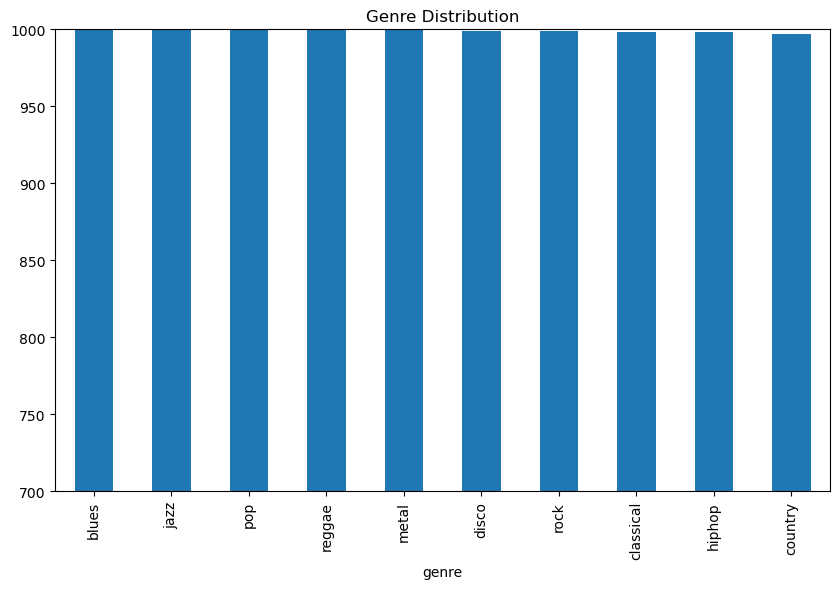

In [33]:
# Check genre class distribution

df['genre'].value_counts().plot(kind='bar', 
                                figsize=(10,6), 
                                title='Genre Distribution')
plt.ylim(700, df['genre'].value_counts().max())
plt.show()

### Boxplots

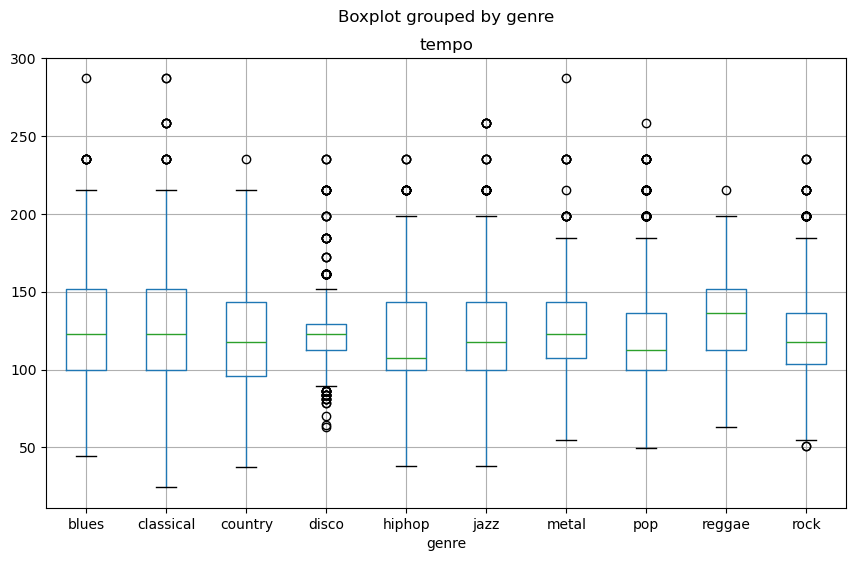

In [34]:
df.boxplot(column = 'tempo',
           by = 'genre', 
           figsize = (10, 6))
plt.show()

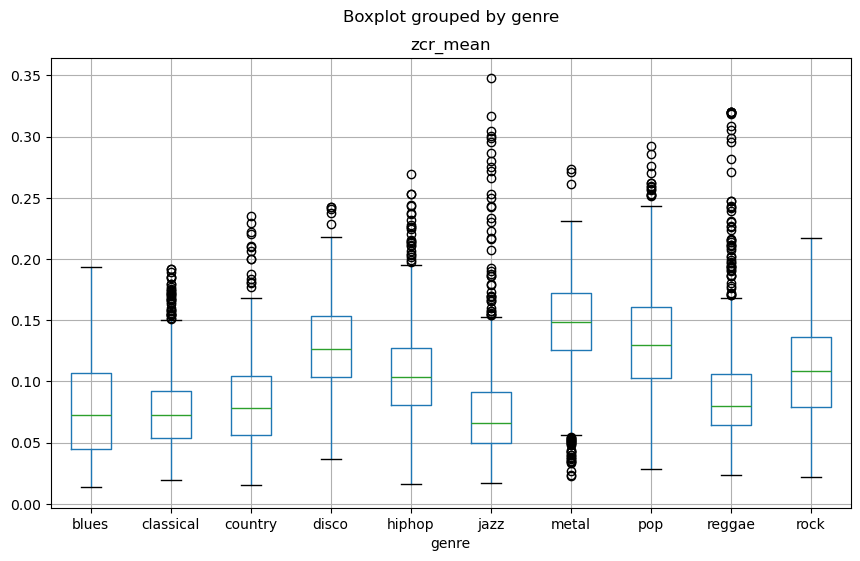

In [35]:
df.boxplot(column = 'zcr_mean',
           by = 'genre', 
           figsize = (10, 6))
plt.show()

### Scatter Plots

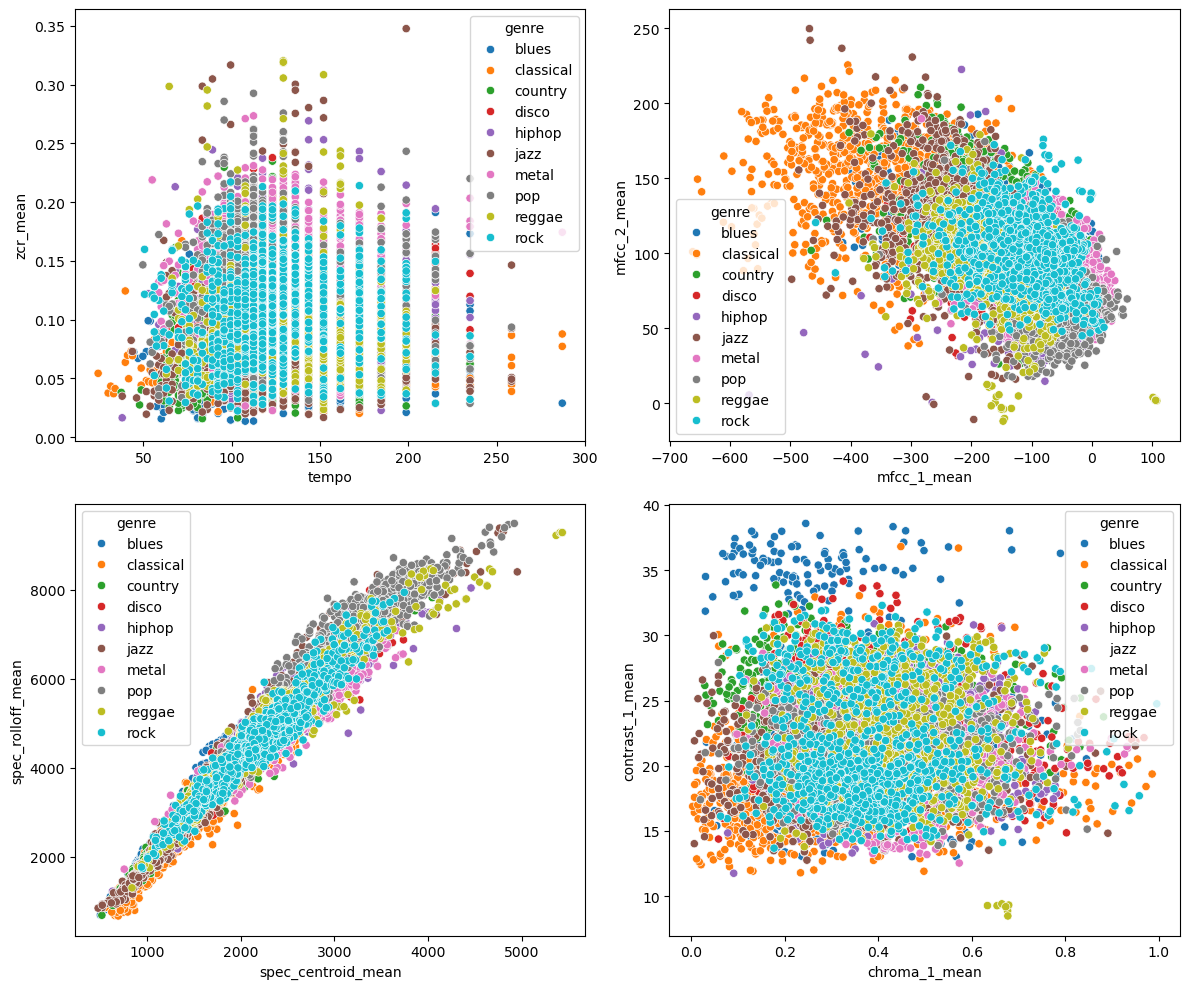

In [36]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(data=df, 
                x="tempo", 
                y="zcr_mean", 
                hue="genre", 
                ax=axes[0,0])

sns.scatterplot(data=df, 
                x="mfcc_1_mean", 
                y="mfcc_2_mean", 
                hue="genre", 
                ax=axes[0,1])

sns.scatterplot(data=df, 
                x="spec_centroid_mean", 
                y="spec_rolloff_mean", 
                hue="genre", 
                ax=axes[1,0])

sns.scatterplot(data=df, 
                x="chroma_1_mean", 
                y="contrast_1_mean", 
                hue="genre", 
                ax=axes[1,1])

f.tight_layout()
plt.show()

### Histograms

In [37]:
df_temp = df.copy()

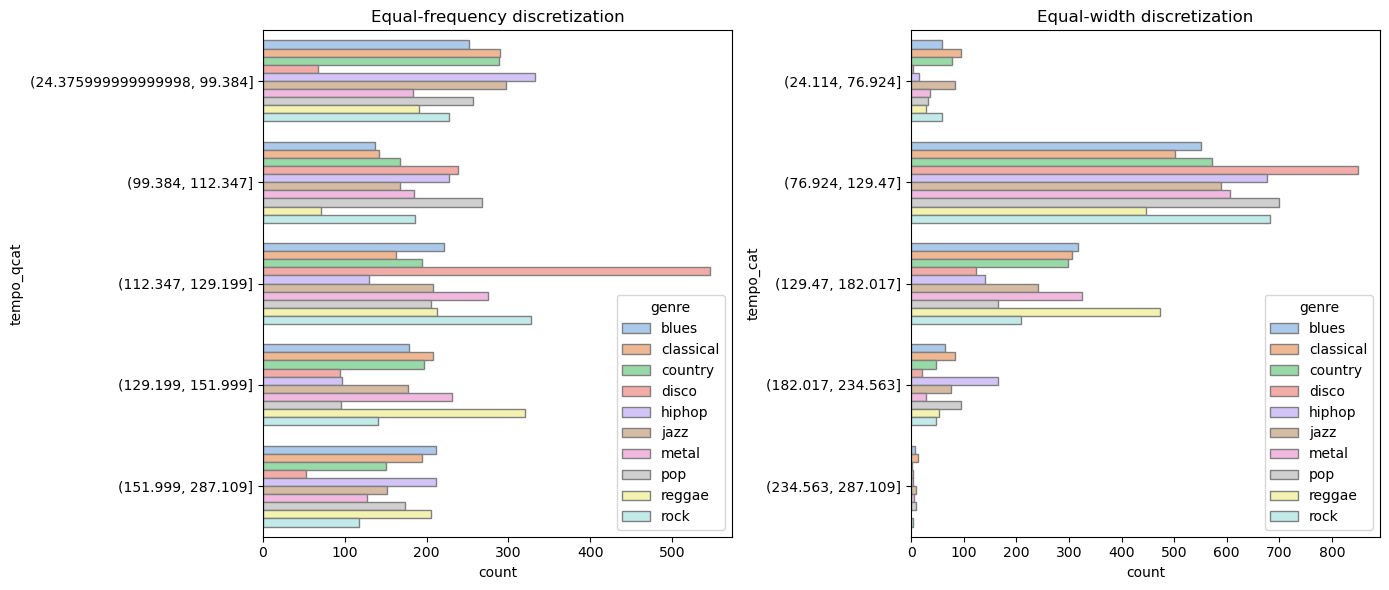

In [38]:
# Exploring distribution of samples between different ranges of "tempo"

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Equal-frequency discretization
df_temp['tempo_qcat'], bins_q = pd.qcut(df['tempo'], 5, retbins=True)
sns.countplot(
    y="tempo_qcat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[0]
)
axes[0].set_title("Equal-frequency discretization")

# Equal-width discretization
df_temp['tempo_cat'], bins_w = pd.cut(df['tempo'], 5, retbins=True)
sns.countplot(
    y="tempo_cat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[1]
)
axes[1].set_title("Equal-width discretization")

plt.tight_layout()
plt.show()

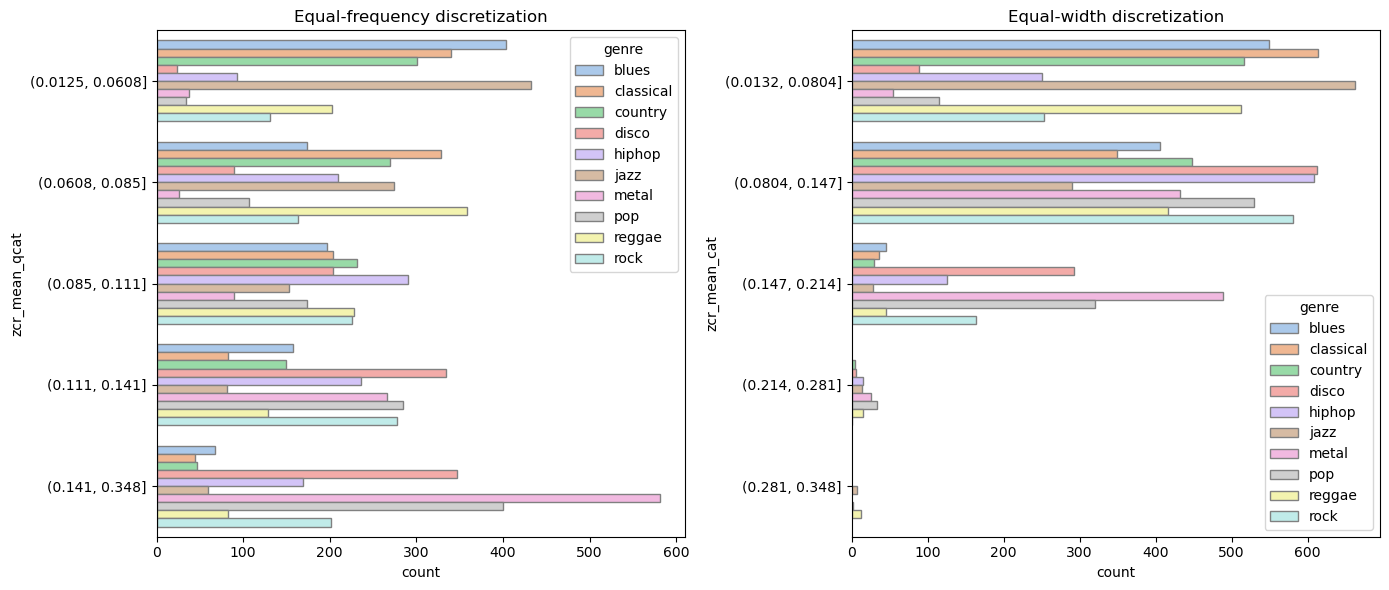

In [39]:
# Exploring distribution of samples between different ranges of "zero crossing rate mean"

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Equal-frequency discretization
df_temp['zcr_mean_qcat'], bins_q = pd.qcut(df['zcr_mean'], 5, retbins=True)
sns.countplot(
    y="zcr_mean_qcat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[0]
)
axes[0].set_title("Equal-frequency discretization")

# Equal-width discretization
df_temp['zcr_mean_cat'], bins_w = pd.cut(df['zcr_mean'], 5, retbins=True)
sns.countplot(
    y="zcr_mean_cat",
    hue="genre",
    palette="pastel",
    edgecolor=".5",
    data=df_temp,
    ax=axes[1]
)
axes[1].set_title("Equal-width discretization")

plt.tight_layout()
plt.show()

In [40]:
df_temp.describe(include = 'category')

,tempo_qcat,tempo_cat,zcr_mean_qcat,zcr_mean_cat
count,9991,9991,9991,9991
unique,5,5,5,5
top,"(112.347, 129.199]","(76.924, 129.47]","(0.0125, 0.0608]","(0.0804, 0.147]"
freq,2485,6172,1999,4672


### Feature Correlation

In [41]:
feature_cols = df.columns.drop('genre') if 'genre' in df.columns else df.columns

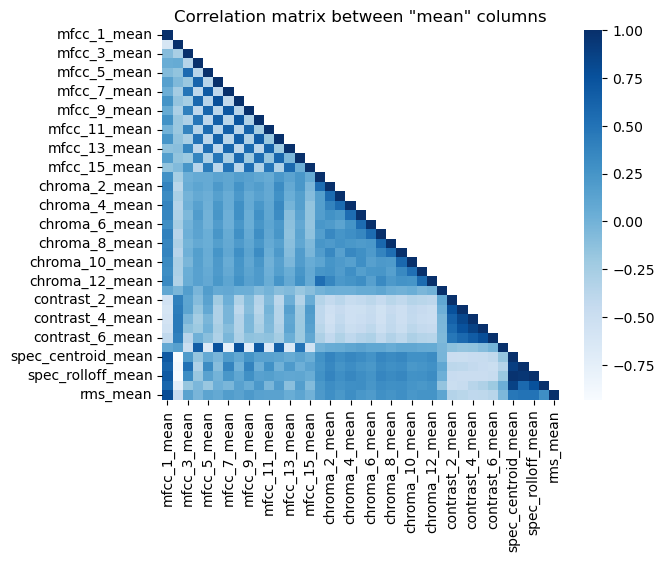

In [42]:
# Correlation matrix between "mean" columns

mean_cols = [col for col in feature_cols if 'mean' in col]
df_mean = df[mean_cols]
corr_mean = df_mean.corr()
corr_mean_lower = corr_mean.where(np.tril(np.ones(corr_mean.shape), k=0).astype(bool))

sns.heatmap(corr_mean_lower, cmap='Blues', annot=False)
plt.title("Correlation matrix between \"mean\" columns")
plt.show()

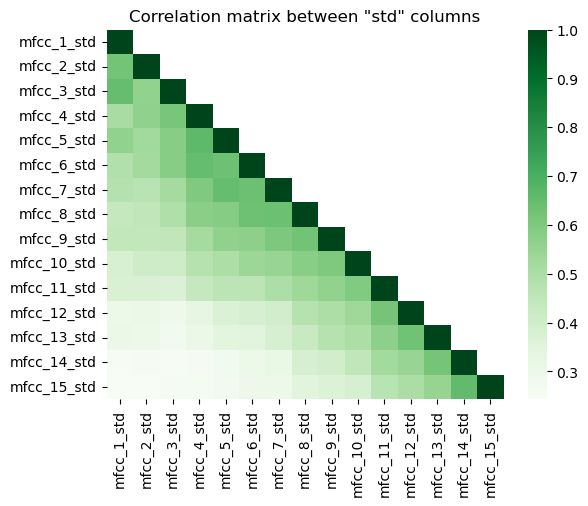

In [43]:
# Correlation matrix between "std" columns

std_cols = [col for col in feature_cols if 'std' in col]
df_std = df[std_cols]
corr_std = df_std.corr()
corr_std_lower = corr_std.where(np.tril(np.ones(corr_std.shape), k=0).astype(bool))

sns.heatmap(corr_std_lower, cmap='Greens', annot=False)
plt.title("Correlation matrix between \"std\" columns")
plt.show()

## Data Preprocessing
As previously shown, there are some highly correlated features in the dataset. With different preprocessing techniques we can reduce the amount of features to make the dataset lighter and increase classifiers performances.

In [44]:
# Read csv to save time on testing

df = pd.read_csv("../df/project_features.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991 entries, 0 to 9990
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mfcc_1_mean          9991 non-null   float64
 1   mfcc_1_std           9991 non-null   float64
 2   mfcc_2_mean          9991 non-null   float64
 3   mfcc_2_std           9991 non-null   float64
 4   mfcc_3_mean          9991 non-null   float64
 5   mfcc_3_std           9991 non-null   float64
 6   mfcc_4_mean          9991 non-null   float64
 7   mfcc_4_std           9991 non-null   float64
 8   mfcc_5_mean          9991 non-null   float64
 9   mfcc_5_std           9991 non-null   float64
 10  mfcc_6_mean          9991 non-null   float64
 11  mfcc_6_std           9991 non-null   float64
 12  mfcc_7_mean          9991 non-null   float64
 13  mfcc_7_std           9991 non-null   float64
 14  mfcc_8_mean          9991 non-null   float64
 15  mfcc_8_std           9991 non-null   f

### Data Scaling

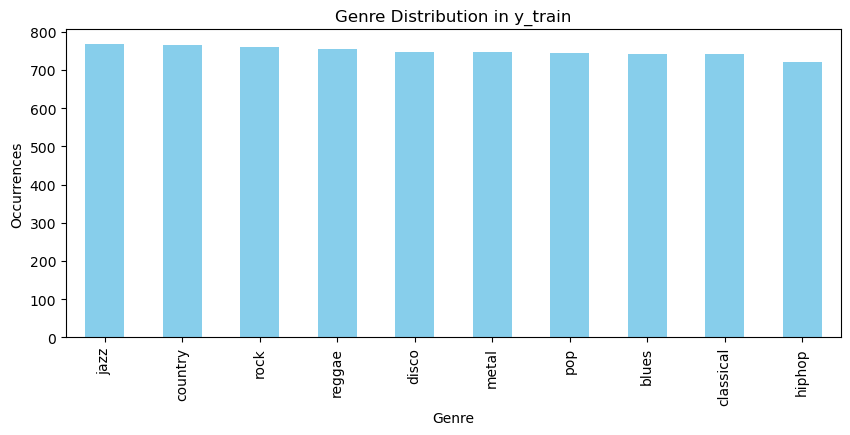

In [45]:
# Separating Train and Test sets to avoid data leakage and inconsistent preprocessing

X = df.drop(columns='genre')
y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

plt.figure(figsize=(10,4))
y_train.value_counts().plot(kind='bar', color='skyblue')
plt.title("Genre Distribution in y_train")
plt.xlabel("Genre")
plt.ylabel("Occurrences")
plt.show()

In [46]:
# Scaling numerical features

scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train) # fit only on training set
X_test_new = scaler.transform(X_test) # transform also the test

X_train_new = pd.DataFrame(X_train_new, columns=X.columns)
X_test_new = pd.DataFrame(X_test_new, columns=X.columns)

X_train_new.shape

(7493, 55)

### Feature Reduction with PCA

Explained variance ratio (no-scaled data): [0.98219813 0.01228081]
Cumulative explained variance ratio (no-scaled data) [0.98219813 0.99447893]
Explained variance ratio (scaled data): [0.20607573 0.16570055]
Cumulative explained variance ratio (scaled data) [0.20607573 0.37177628]


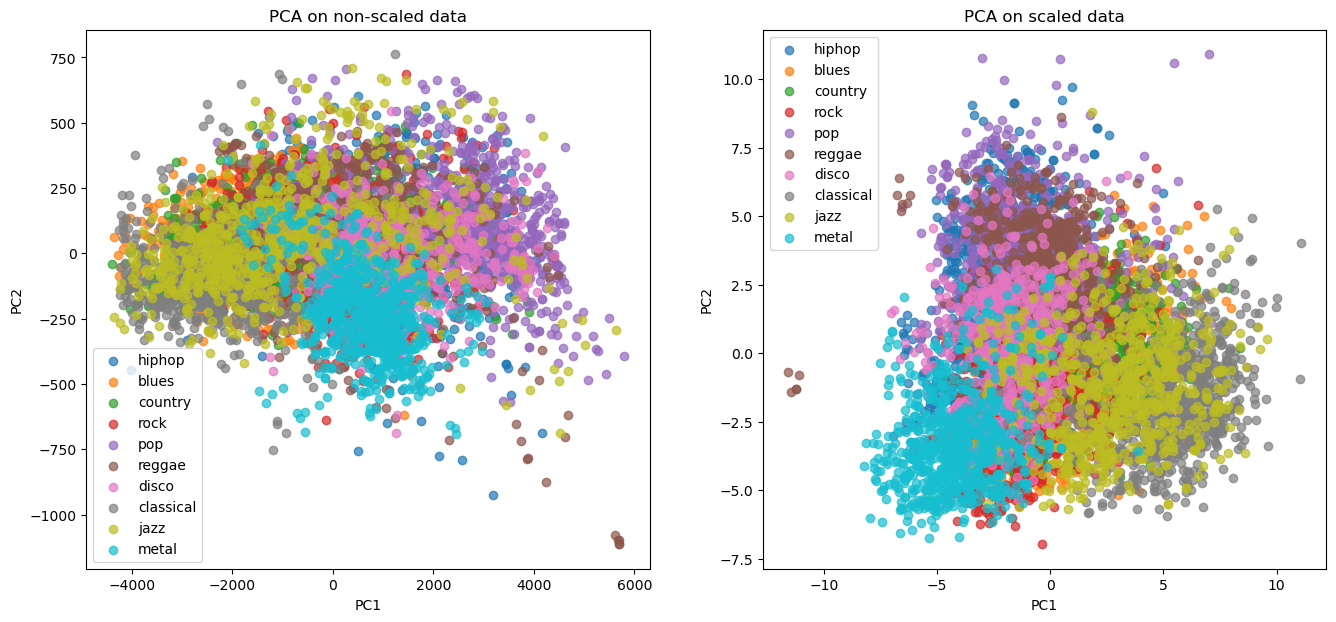

In [47]:
# Comparing PCA on non-scaled and scaled data
# This block is only made to show PCA benefits

pca_noscaled = PCA(n_components=2)
pca_scaled = PCA(n_components=2)
X_noscaled_pca = pca_noscaled.fit_transform(X_train)
X_scaled_pca = pca_scaled.fit_transform(X_train_new)

# Not tranforming test data because this block is only made to compare PCA with non-scaled and scaled data

df_noscaled = pd.DataFrame(X_noscaled_pca, columns=['PC1', 'PC2'])
df_noscaled['genre'] = y_train.values

df_scaled = pd.DataFrame(X_scaled_pca, columns=['PC1', 'PC2'])
df_scaled['genre'] = y_train.values

print("Explained variance ratio (no-scaled data):", pca_noscaled.explained_variance_ratio_)
print("Cumulative explained variance ratio (no-scaled data)", pca_noscaled.explained_variance_ratio_.cumsum())

print("Explained variance ratio (scaled data):", pca_scaled.explained_variance_ratio_)
print("Cumulative explained variance ratio (scaled data)", pca_scaled.explained_variance_ratio_.cumsum())

fig, axes = plt.subplots(1, 2, figsize=(16,7))

for g in df_noscaled['genre'].unique():
    subset = df_noscaled[df_noscaled['genre'] == g]
    axes[0].scatter(subset['PC1'], subset['PC2'], label=g, alpha=0.7)
axes[0].set_title('PCA on non-scaled data')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()

for g in df_scaled['genre'].unique():
    subset = df_scaled[df_scaled['genre'] == g]
    axes[1].scatter(subset['PC1'], subset['PC2'], label=g, alpha=0.7)
axes[1].set_title('PCA on scaled data')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend()

plt.show()


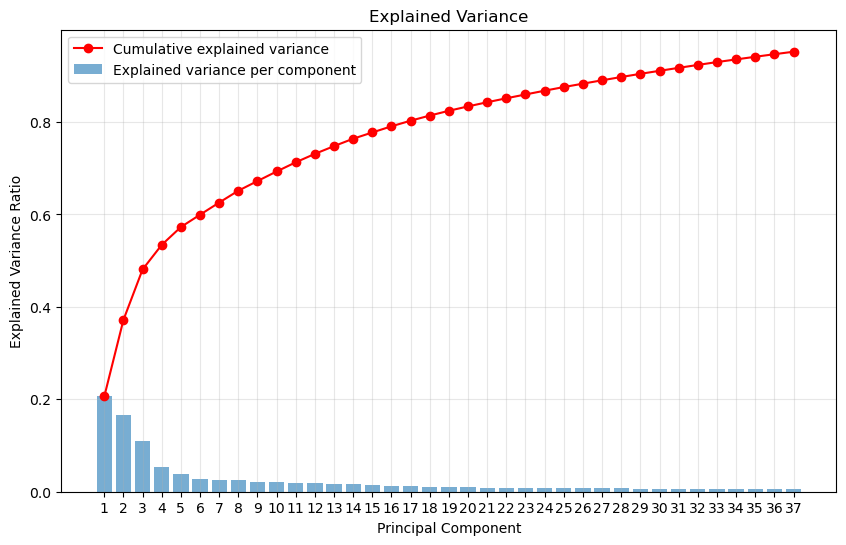

In [48]:
# Feature reduction using PCA with fixed cumulative variance

cumulative_var_th = 0.95

pca = PCA(n_components=cumulative_var_th)
X_train_pca = pca.fit_transform(X_train_new)
X_test_pca = pca.transform(pd.DataFrame(X_test_new, columns=X_train_new.columns))

df_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
df_pca['genre'] = y_train.values
df_pca.to_csv('../df/project_features_pca.csv', index=False)

explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()
components = np.arange(1, len(explained_var)+1)

plt.figure(figsize=(10,6))
plt.bar(components, explained_var, alpha=0.6, label='Explained variance per component')
plt.plot(components, cumulative_var, marker='o', color='red', label='Cumulative explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance')
plt.xticks(components)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [49]:
# Feature reduction rateo

print("Training set shape before PCA:", X_train.shape) 
print("Training set shape after PCA:", X_train_pca.shape) 
print("Feature reduction rateo", X_train_pca.shape[1] / X_train.shape[1]) 

Training set shape before PCA: (7493, 55)
Training set shape after PCA: (7493, 37)
Feature reduction rateo 0.6727272727272727


In [50]:
# Shows the 5 Most important features for each of the 10 most influent PCA components

loadings = pd.DataFrame(pca.components_, columns=X.columns)
loadings.index = [f'PC{i+1}' for i in range(loadings.shape[0])]

top_features_per_pc = {}
for pc in loadings.index[:10]:  
    top_features = loadings.loc[pc].abs().sort_values(ascending=False).head(5).index.tolist()
    top_features_per_pc[pc] = top_features

for pc, features in top_features_per_pc.items():
    print(f"{pc}: {features}")

PC1: ['contrast_3_mean', 'contrast_4_mean', 'contrast_5_mean', 'mfcc_1_mean', 'contrast_2_mean']
PC2: ['mfcc_6_std', 'mfcc_4_std', 'mfcc_2_std', 'mfcc_7_mean', 'contrast_7_mean']
PC3: ['contrast_7_mean', 'mfcc_7_std', 'mfcc_11_std', 'mfcc_9_std', 'mfcc_7_mean']
PC4: ['zcr_mean', 'spec_centroid_mean', 'spec_rolloff_mean', 'mfcc_2_mean', 'spec_bandwidth_mean']
PC5: ['mfcc_14_mean', 'mfcc_15_mean', 'mfcc_13_mean', 'contrast_1_mean', 'mfcc_12_mean']
PC6: ['chroma_3_mean', 'chroma_10_mean', 'mfcc_3_mean', 'chroma_4_mean', 'chroma_9_mean']
PC7: ['mfcc_3_mean', 'chroma_10_mean', 'contrast_1_mean', 'chroma_9_mean', 'chroma_11_mean']
PC8: ['chroma_6_mean', 'chroma_7_mean', 'chroma_1_mean', 'chroma_5_mean', 'chroma_2_mean']
PC9: ['chroma_1_mean', 'contrast_1_mean', 'rms_mean', 'chroma_12_mean', 'chroma_4_mean']
PC10: ['chroma_3_mean', 'chroma_6_mean', 'chroma_1_mean', 'rms_mean', 'chroma_4_mean']


## Classifier Model Selection

In this section, I am going to test the different classifier models on 3 different dataframes:
- Scaled Features
- PCA Reduced Features
- RFE Reduced Features

The final selected model will be the one that shows the best accuracy performances while using the less feature possible. 

### Models Initialization

In [51]:
# Initializing models with different parameters

models = {
    "LogisticRegression": (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["lbfgs"]
        }
    ),
    "SVM": (
        LinearSVC(max_iter=5000, random_state=42),
        {
            "C": [0.1, 1, 10]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    )
}

### Testing Classifiers on all features

In [52]:
# Testing classification 

results = []

for name, (model, param_grid) in models.items():
    print(f"%%%%%%%%%% Training {name}... %%%%%%%%%%")

    # GridSearch with 5-fold cross-validation

    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_new, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_new)
    
    score = best_model.score(X_test_new, y_test)
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV Best Score": grid.best_score_,
        "Test Accuracy": score
    })
    
    print(f"\n{name} results:")
    print("Best Params:", grid.best_params_)
    print("CV Best Score:", grid.best_score_)
    print("Test Accuracy:", score)
    print("Classification Report:\n", classification_report(y_test, y_pred))

results_df = pd.DataFrame(results)

%%%%%%%%%% Training LogisticRegression... %%%%%%%%%%

LogisticRegression results:
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
CV Best Score: 0.7253455129409816
Test Accuracy: 0.7397918334667735
Classification Report:
               precision    recall  f1-score   support

       blues       0.73      0.81      0.77       257
   classical       0.90      0.95      0.92       256
     country       0.70      0.69      0.69       232
       disco       0.66      0.58      0.62       251
      hiphop       0.71      0.71      0.71       276
        jazz       0.79      0.84      0.81       232
       metal       0.82      0.89      0.85       254
         pop       0.78      0.80      0.79       256
      reggae       0.65      0.61      0.63       245
        rock       0.60      0.50      0.55       239

    accuracy                           0.74      2498
   macro avg       0.73      0.74      0.73      2498
weighted avg       0.73      0.74      0.74      2498

%%%%%%%%

In [53]:
print("\n Models Comparison:")
print(results_df)


 Models Comparison:
                Model                                        Best Params  \
0  LogisticRegression      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}   
1                 SVM                                          {'C': 10}   
2        RandomForest  {'max_depth': 20, 'min_samples_split': 2, 'n_e...   

   CV Best Score  Test Accuracy  
0       0.725346       0.739792  
1       0.704793       0.713771  
2       0.846655       0.881105  


### Testing Classifiers after PCA feature reduction 

In [54]:
# Testing Classifiers with PCA features

results_pca = []
predictions_pca = {}

for name, (model, param_grid) in models.items():
    print(f"%%%%%%%%%% Training {name} with PCA features... %%%%%%%%%%")
    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_pca, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_pca)
    
    predictions_pca[name] = (y_test, y_pred, best_model.classes_)
    
    results_pca.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV Best Score": grid.best_score_,
        "Test Accuracy": best_model.score(X_test_pca, y_test)
    })

    print(f"\n{name} results:")
    print("Best Params:", grid.best_params_)
    print("CV Best Score:", grid.best_score_)
    print("Test Accuracy:", score)
    print("Classification Report:\n", classification_report(y_test, y_pred))


%%%%%%%%%% Training LogisticRegression with PCA features... %%%%%%%%%%

LogisticRegression results:
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
CV Best Score: 0.6748962147439637
Test Accuracy: 0.8811048839071257
Classification Report:
               precision    recall  f1-score   support

       blues       0.62      0.64      0.63       257
   classical       0.88      0.93      0.90       256
     country       0.57      0.54      0.56       232
       disco       0.59      0.53      0.56       251
      hiphop       0.67      0.68      0.67       276
        jazz       0.72      0.72      0.72       232
       metal       0.78      0.89      0.83       254
         pop       0.70      0.80      0.75       256
      reggae       0.64      0.58      0.61       245
        rock       0.50      0.43      0.46       239

    accuracy                           0.68      2498
   macro avg       0.67      0.67      0.67      2498
weighted avg       0.67      0.68      0.67  

In [55]:
results_pca_df = pd.DataFrame(results_pca)
print("\nModels comparison after PCA:")
print(results_pca_df)


Models comparison after PCA:
                Model                                        Best Params  \
0  LogisticRegression      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}   
1                 SVM                                          {'C': 10}   
2        RandomForest  {'max_depth': 20, 'min_samples_split': 2, 'n_e...   

   CV Best Score  Test Accuracy  
0       0.674896       0.676141  
1       0.646736       0.636910  
2       0.798343       0.825460  


### Testing Classifiers after RFE feature reduction 

In [56]:
# Feature selection with RFE

results_rfe = []
predictions_rfe = {}

for name, (model, param_grid) in models.items():
    print(f"\n%%%%%%%%%% Feature selection + training for {name}... %%%%%%%%%%")
    
    # RFECV uses current model feature importance score to select significant features

    selector = RFECV(estimator=model, step=1, cv=5, scoring="accuracy", n_jobs=-1)
    X_train_sel = selector.fit_transform(X_train_new, y_train)
    X_test_sel = selector.transform(X_test_new)
    
    print(f"{name} selected {X_train_sel.shape[1]} features")
    
    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_sel, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    
    predictions_rfe[name] = (y_test, y_pred, best_model.classes_)
    
    results_rfe.append({
        "Model": name,
        "Num Features": X_train_sel.shape[1],
        "Best Params": grid.best_params_,
        "CV Best Score": grid.best_score_,
        "Test Accuracy": best_model.score(X_test_sel, y_test)
    })

    print(f"\n{name} results:")
    print("Best Params:", grid.best_params_)
    print("CV Best Score:", grid.best_score_)
    print("Test Accuracy:", score)
    print("Classification Report:\n", classification_report(y_test, y_pred))



%%%%%%%%%% Feature selection + training for LogisticRegression... %%%%%%%%%%
LogisticRegression selected 55 features

LogisticRegression results:
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
CV Best Score: 0.7253455129409816
Test Accuracy: 0.8811048839071257
Classification Report:
               precision    recall  f1-score   support

       blues       0.73      0.81      0.77       257
   classical       0.90      0.95      0.92       256
     country       0.70      0.69      0.69       232
       disco       0.66      0.58      0.62       251
      hiphop       0.71      0.71      0.71       276
        jazz       0.79      0.84      0.81       232
       metal       0.82      0.89      0.85       254
         pop       0.78      0.80      0.79       256
      reggae       0.65      0.61      0.63       245
        rock       0.60      0.50      0.55       239

    accuracy                           0.74      2498
   macro avg       0.73      0.74      0.73      249

In [57]:
results_rfe_df = pd.DataFrame(results_rfe)
print("\nModels Comparison with RFE:")
print(results_rfe_df)


Models Comparison with RFE:
                Model  Num Features  \
0  LogisticRegression            55   
1                 SVM            52   
2        RandomForest            30   

                                         Best Params  CV Best Score  \
0      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}       0.725346   
1                                           {'C': 1}       0.705994   
2  {'max_depth': 20, 'min_samples_split': 2, 'n_e...       0.852796   

   Test Accuracy  
0       0.739792  
1       0.710568  
2       0.882706  


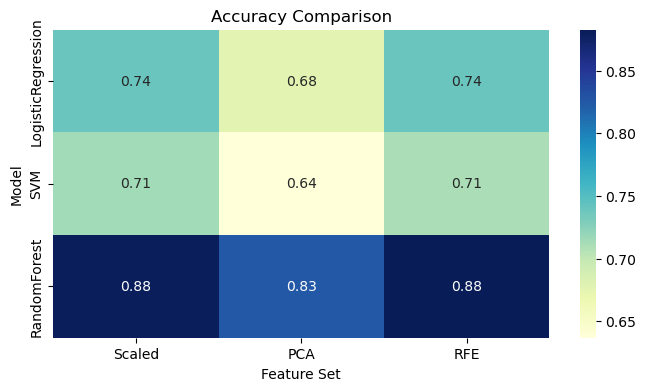

In [61]:
# Models Accuracy Comparison

results_heatmap = {
    "Scaled": results_df.set_index("Model")["Test Accuracy"],
    "PCA": results_pca_df.set_index("Model")["Test Accuracy"],
    "RFE": results_rfe_df.set_index("Model")["Test Accuracy"]
}

df_results_heatmap = pd.DataFrame(results_heatmap)

plt.figure(figsize=(8,4))
sns.heatmap(df_results_heatmap, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Accuracy Comparison")
plt.xlabel("Feature Set")
plt.ylabel("Model")
plt.show()